<a href="https://colab.research.google.com/github/satishgunjal/Machine-Learning-Using-Python/blob/master/07_Logistic_Regression_Binary_Classification/Exercise_Logistic_Regression_Binary_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise Logistic Regression Binary Classification

1.   Download employee retention dataset from here: https://www.kaggle.com/giripujar/hr-analytics.
2.   Now do some exploratory data analysis to figure out which variables have direct and clear impact on employee retention (i.e. whether they leave the company or continue to work)
3.   Plot bar charts showing impact of employee salaries on retention 
4.   Plot bar charts showing corelation between department and employee retention
5.   Now build logistic regression model using variables that were narrowed down in step 1
6.   Measure the accuracy of the model

Load the data in pandas frame

In [0]:
import pandas as pd

# Use this if ur running notebook locally
#df = pd.read_csv('exercise_hr_comma_sep.csv')
#df

In [3]:
from google.colab import files

uploaded = files.upload()

Saving exercise_hr_comma_sep.csv to exercise_hr_comma_sep.csv


In [6]:
import io

df = pd.read_csv(io.StringIO(uploaded['exercise_hr_comma_sep.csv'].decode('utf-8')))
df.shape

(14999, 10)

Total number of rows(training examples) are 14999
Total number of columns(features) are 10 

In [19]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


##Data exploration and visualization

Now lets check the data where 'left' = 1 (employees left)

In [22]:
df_left = df[df['left'] == 1]
df_left.shape

(3571, 10)

Check the data where left = 0 (retained)

In [23]:
df_retained = df[df['left'] == 0]
df_retained.shape

(11428, 10)

**Get average numbers for all columns**

In [25]:
df.groupby('left').mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years
left,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321


**From our data visualization we can conclude**

1.   Satisfaction level of retained emplyees is higher(0.66) than left(0.44) ones
2.   Average monthly hours of left(207) emplyees are higher than the retaioned ones(199)
3.   Also the employees who has given promotion in last 5 years are likely to be retained



***Note here since Department and salary values are in string format we havent received any mean for it. So to check its impact on employee retaintion lets plot the charts and analyse it better.***

## Plot bar charts showing impact of employee salaries on retention

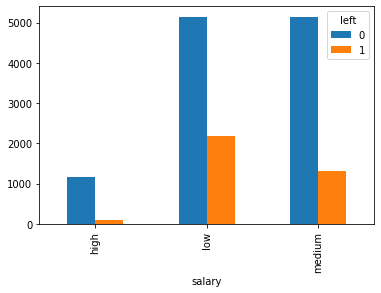

In [26]:
pd.crosstab(df.salary,df.left).plot(kind='bar')

From above bar chart we can conclude that employees with higher salary are likely to not leave the company

## Plot bar charts showing corelation between department and employee retention

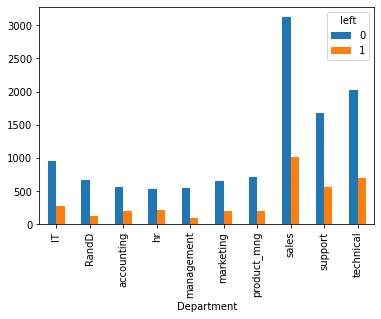

In [27]:
pd.crosstab(df.Department,df.left).plot(kind='bar')

From above chart there is some impact of department on emplyee retaintion, but since its not major we can ignore it

## Fianl independent variables
From data analysis os far we can use below variables in our model


1.   satisfaction_level
2.   average_montly_hours
3.   promotion_last_5years
4.   salary

Lets create separate dataframe of these variables

In [28]:
subdf = df[['satisfaction_level', 'average_montly_hours', 'promotion_last_5years', 'salary']]
subdf.head()

,satisfaction_level,average_montly_hours,promotion_last_5years,salary
0,0.38,157,0,low
1,0.80,262,0,medium
2,0.11,272,0,medium
3,0.72,223,0,low
4,0.37,159,0,low


## Handling Salary 'Text' data
Since salary column contains data in text format and to use it in our model we must convert it into numeric format. 
We will use 'One Hot Encoding' techinuue to do it. [Reference](04_One_Hot_Encoding/One_Hot_Encoding.ipynb)

We will use pandas get_dummies method to create dummy variables for salry column

In [30]:
dummies_salary = pd.get_dummies(subdf.salary, prefix='salary') # to prepfix the values of each dummy column by 'salary'
dummies_salary.head()

,salary_high,salary_low,salary_medium
0,0,1,0
1,0,0,1
2,0,0,1
3,0,1,0
4,0,1,0


Now we must add this dataframe to subdf dataframe

In [33]:
subdf_with_dummies = pd.concat([subdf,dummies_salary],axis='columns')
subdf_with_dummies.head()

,satisfaction_level,average_montly_hours,promotion_last_5years,salary,salary_high,salary_low,salary_medium
0,0.38,157,0,low,0,1,0
1,0.80,262,0,medium,0,0,1
2,0.11,272,0,medium,0,0,1
3,0.72,223,0,low,0,1,0
4,0.37,159,0,low,0,1,0


Now we must drop the original salary column as well as one of the dummy variable column to avoid the 'Dummy Variable Trap' problem

***Note that sklearn linear regression model will automatically drop one of the dummy variable column, but its good practice do it by yourself.***

In [34]:
subdf_with_dummies = subdf_with_dummies.drop(['salary','salary_medium'], axis='columns')
subdf_with_dummies.head()
# another syntax is
#subdf_with_dummies.drop(['salary','salary_medium'],axis='columns', inplace=True) # 'inplace' will update the dataframe with changes

,satisfaction_level,average_montly_hours,promotion_last_5years,salary_high,salary_low
0,0.38,157,0,0,1
1,0.80,262,0,0,0
2,0.11,272,0,0,0
3,0.72,223,0,0,1
4,0.37,159,0,0,1


Now lets assign the values to X variable

In [35]:
X =subdf_with_dummies
X.head()

,satisfaction_level,average_montly_hours,promotion_last_5years,salary_high,salary_low
0,0.38,157,0,0,1
1,0.80,262,0,0,0
2,0.11,272,0,0,0
3,0.72,223,0,0,1
4,0.37,159,0,0,1


Lets assign values to y variable

In [37]:
y = df.left
y.head()

0    1
1    1
2    1
3    1
4    1
Name: left, dtype: int64

Since we have X and y variables lets create the training and testing data

In [60]:
from sklearn.model_selection import train_test_split # import train_test_split class

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.3)
len(X_train)

4499

Now lets train the Logistic regression model

In [0]:
from sklearn.linear_model import LogisticRegression # import the LogisticRegression class
model= LogisticRegression() # create an object(classifier) of the class


In [62]:
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [76]:
model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [64]:
model.score(X_test,y_test)

0.7794285714285715